In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from warnings import simplefilter
warnings.filterwarnings("ignore", category =UserWarning,)

import gc
import pickle
from collections import OrderedDict
from pyproj import Transformer
import numpy as np
import pandas as pd
import iris
import glob
import sys
import os
import cartopy.crs as ccrs
import itertools
from scipy import spatial
import numpy.ma as ma
import tilemapbase
from math import cos, radians
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from pyproj import Proj, transform

from Identify_Events_Functions import *

In [2]:
pd.set_option('display.float_format', '{:.3f}'.format)

def find_amax_indy_events_v2 (df, duration, Tb0):
    
    rainfall_cores = find_rainfall_core(df, duration=duration, Tb0= Tb0)
    rainfall_events_expanded= []

    for rainfall_core in rainfall_cores:
        rainfall_core_after_search1 = search1(df, rainfall_core)
        rainfall_core_after_search2 = search2(df, rainfall_core_after_search1)
        rainfall_core_after_search3 = search3(df, rainfall_core_after_search2, Tb0= Tb0)
        # If the event is not entirely dry 
        if len(rainfall_core_after_search3[rainfall_core_after_search3['precipitation (mm/hr)']>0.1]) >0:
            rainfall_events_expanded.append(rainfall_core_after_search3)
    
    return rainfall_events_expanded

def find_gauge_Tb0_and_location_in_grid (gauge_num, sample_cube):
    # Get data just for this gauge
    gauge1 = tbo_vals.iloc[gauge_num]
    # Find the interevent arrival time (Tb0)
    Tb0 = int(gauge1['Critical_interarrival_time'])
    # Find the coordinates of the cell containing this gauge
    closest_point, idx_2d = find_position_obs(sample_cube,gauge1['Lat'], gauge1['Lon'], plot_radius = 30, plot=False)
    
    return Tb0, idx_2d

In [3]:
def load_and_cache_cube(year, cache, filenames_pattern):
    if year in cache:
        print(f"Using cached data for year {year}")
        return cache[year]

    print(f"Loading data for year {year}")
    filenames = [filename for filename in glob.glob(filenames_pattern) if f'pr{year}' in filename]

    if not filenames:
        raise FileNotFoundError(f"No files found for the year {year} with pattern {filenames_pattern}")

    cubes = iris.load(filenames)
    try:
        cube = cubes.concatenate_cube()
    except iris.exceptions.ConcatenateError as e:
        # Handle concatenation error by unifying metadata
        for c in cubes:
            c.rename(cubes[0].name())
        cube = cubes.merge_cube()
    
    cache[year] = cube

    return cube

def save_cube_to_disk(cube, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(cube, f)

def load_cube_from_disk(filepath):
    with open(filepath, 'rb') as f:
        return pickle.load(f)
    
# Custom limited-size cache
class LimitedSizeDict(OrderedDict):
    def __init__(self, *args, max_size=100, **kwargs):
        self.max_size = max_size
        super().__init__(*args, **kwargs)

    def __setitem__(self, key, value):
        if len(self) >= self.max_size:
            self.popitem(last=False)
        OrderedDict.__setitem__(self, key, value)    

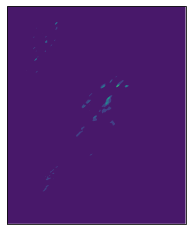

In [9]:
import iris.plot as iplt
iplt.contourf(sample_cube)

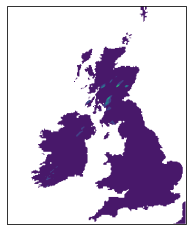

In [10]:
# Sample cube is not masked
sample_cube = iris.load(f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/2.2km_bng_masked/{em}/2002_2020/bng_{em}a.pr200508*')[0][1,:,:]
iplt.contourf(sample_cube)

In [16]:
sample_cube.data.mask

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [17]:
np.unique(sample_cube.data.mask, return_counts=True)

(array([False,  True]), array([ 67272, 152265]))

In [ ]:
em='bc012'

# Initialize a limited-size cache
cube_cache = LimitedSizeDict(max_size=10)

# Loop through gauges
for gauge_num in range(0, 1300):
    print(f"Processing gauge {gauge_num}")

    # Check if the directory exists for this gauge
    dir_this_gauge = f"../../../ProcessedData/IndependentEvents/UKCP18_30mins/{em}/{gauge_num}/"
    if not os.path.isdir(dir_this_gauge):
        os.makedirs(dir_this_gauge)
    
    # Find the Tb0 and index of this gauge
    # Get tb0 values at each gauge
    tbo_vals = pd.read_csv('/nfs/a319/gy17m2a/PhD/datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')

    # Read in a sample cube for finding the location of gauge in grid
    # Sample cube is not masked
    sample_cube = iris.load(f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/2.2km_bng/{em}/2002_2020/bng_{em}a.pr200508*')[0][1,:,:]
    
    Tb0, idx_2d = find_gauge_Tb0_and_location_in_grid(gauge_num, sample_cube)

    for yr in range(2001, 2020):
        # Check if any files are missing for this year
        if not any(os.path.exists(f"{dir_this_gauge}/{duration}hrs_{yr}_v2_part0.csv") for duration in [0.5, 1, 2, 3, 6, 12, 24]):
            
            # Load data for this year
            general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_every30mins/2.2km_bng/{em}/2002_2020/bng_{em}a.pr{yr}*'
            cache_filepath = f"/nfs/a319/gy17m2a/PhD/datadir/cache/UKCP18_30mins_{em}/cube_{yr}.pkl"
            
            try:
                if yr not in cube_cache:
                    if os.path.exists(cache_filepath):
                        cube = load_cube_from_disk(cache_filepath)
                    else:
                        cube = load_and_cache_cube(yr, cube_cache, general_filename)
                        save_cube_to_disk(cube, cache_filepath)
                else:
                    cube = cube_cache[yr]
            except (EOFError, FileNotFoundError) as e:
                print(f"Error loading cube for year {yr}: {e}")
                continue

            # Extract data for the specified indices
            data = cube[:, idx_2d[0], idx_2d[1]].data

            # Create a DataFrame from the data
            df = pd.DataFrame(data, columns=['precipitation (mm/hr)'])
            df['times'] = cube[:,idx_2d[0],idx_2d[1]].coord('time').units.num2date(cube.coord('time').points)
            df['precipitation (mm)'] = df['precipitation (mm/hr)'] / 2   

            # Loop through duration
            for duration in [0.5, 1, 2, 3, 6, 12, 24]:
                # Check if this duration is missing
                if not os.path.exists(f"{dir_this_gauge}/{duration}hrs_{yr}_v2_part0.csv"):
                    print(f"Finding the AMAX for {duration}hr events for gauge {gauge_num} in year {yr}")

                    # Find event (might be more than one)
                    events_v2 = find_amax_indy_events_v2(df, duration=duration, Tb0=Tb0)

                    # For each of the events
                    for num, event in enumerate(events_v2):
                        if len(event) > 1:
                            event.to_csv(f"{dir_this_gauge}/{duration}hrs_{yr}_v2_part{num}.csv")
        else:
            print(f"All files already exist for gauge {gauge_num} and year {yr}")

        # Collect garbage to free up memory
        gc.collect()


Processing gauge 0
(178, 318)
All files already exist for gauge 0 and year 2001
All files already exist for gauge 0 and year 2002
All files already exist for gauge 0 and year 2003
All files already exist for gauge 0 and year 2004
All files already exist for gauge 0 and year 2005
All files already exist for gauge 0 and year 2006
All files already exist for gauge 0 and year 2007
All files already exist for gauge 0 and year 2008
All files already exist for gauge 0 and year 2009
All files already exist for gauge 0 and year 2010
All files already exist for gauge 0 and year 2011
All files already exist for gauge 0 and year 2012
All files already exist for gauge 0 and year 2013
All files already exist for gauge 0 and year 2014
All files already exist for gauge 0 and year 2015
All files already exist for gauge 0 and year 2016
All files already exist for gauge 0 and year 2017
All files already exist for gauge 0 and year 2018
All files already exist for gauge 0 and year 2019
Processing gauge 1
(

All files already exist for gauge 8 and year 2008
All files already exist for gauge 8 and year 2009
All files already exist for gauge 8 and year 2010
All files already exist for gauge 8 and year 2011
All files already exist for gauge 8 and year 2012
All files already exist for gauge 8 and year 2013
All files already exist for gauge 8 and year 2014
All files already exist for gauge 8 and year 2015
All files already exist for gauge 8 and year 2016
All files already exist for gauge 8 and year 2017
All files already exist for gauge 8 and year 2018
All files already exist for gauge 8 and year 2019
Processing gauge 9
(270, 312)
All files already exist for gauge 9 and year 2001
All files already exist for gauge 9 and year 2002
All files already exist for gauge 9 and year 2003
All files already exist for gauge 9 and year 2004
All files already exist for gauge 9 and year 2005
All files already exist for gauge 9 and year 2006
All files already exist for gauge 9 and year 2007
All files already ex

All files already exist for gauge 16 and year 2013
All files already exist for gauge 16 and year 2014
All files already exist for gauge 16 and year 2015
All files already exist for gauge 16 and year 2016
All files already exist for gauge 16 and year 2017
All files already exist for gauge 16 and year 2018
All files already exist for gauge 16 and year 2019
Processing gauge 17
(269, 290)
All files already exist for gauge 17 and year 2001
All files already exist for gauge 17 and year 2002
All files already exist for gauge 17 and year 2003
All files already exist for gauge 17 and year 2004
All files already exist for gauge 17 and year 2005
All files already exist for gauge 17 and year 2006
All files already exist for gauge 17 and year 2007
All files already exist for gauge 17 and year 2008
Finding the AMAX for 0.5hr events for gauge 17 in year 2009
Finding the AMAX for 1hr events for gauge 17 in year 2009
Finding the AMAX for 2hr events for gauge 17 in year 2009
Finding the AMAX for 3hr eve